# Aide à la décision pour le mode d'imposition en tant que micro-entrepreneur au régime micro-fiscal
Choix entre les régimes :
- barème progressif de l'impôt sur le revenu avec abattement
- impôt libératoire sur le revenu sans abattement

Dans chaque cas, l'impôt est directement calculé sur le chiffre d'affaire (CA), et non sur les bénéfices.

## Paramètres

### Mon entreprise

In [217]:
# Type d'activité de la micro entreprise
# 'BNC', 'BIC_AUTRES', 'BIC_ACHAT_REVENTE'
REGIME = 'BNC'

# CA total : ceci est le CA avant abattement
CA_PERSO_BRUT = 12000

# Nombre de parts de quotient familial
N_PARTS_Q_FAMIL = 1

### Seuils et taux réglementaires au 05-11-2020

In [218]:
# Impôt libératoire
IMP_LIB = 0.022

# Abattements sur CA
DIC_ABATTEMENTS = {'BNC':0.34,
                   'BIC_AUTRES':0.5,
                   'BIC_ACHAT_REVENTE':0.71}

# Abattement plancher
ABATTEMENT_MINIMUM = 305

# Barème impôt sur le revenu 11-2020
LIST_DICS_TAUX_TRANCHE = [
    {'borne_inf': 10065,
     'borne_sup': 25659,
     'taux': 0.11},
    {'borne_inf': 25660,
     'borne_sup': 73369,
     'taux': 0.3},
    {'borne_inf':73370,
     'borne_sup': 157806,
     'taux': 0.41},
    {'borne_inf':157807,
     'taux': 0.45}
]

# Seuils au-delà desquels l'option de l'impot
# libératoire sur le revenu n'est plus possible

# Revenu fiscal de référence de 2018, pour une application
# au 1er janvier 2020, en fonction de la part de quotient familial.
# ex : 1 part de quotient familial (personne seule) => seuil 27519€
DIC_SEUILS_OPTION_LIB = {1: 27519,
                         2: 55038,
                         2.5: 68797.5,
                         3: 82557}

### Ensemble des CA à visualiser

In [ ]:
# 10000, 11000, ..., 32000
LISTE_CA = [i*1000 for i in range(10, 32)]

## Imports

In [ ]:
# Graphs et couche design
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Fonctions

In [170]:
def calcul_impots_bareme_progressif(ca, list_dics_taux_tranche):
    """ 
    Calcule le montant d'impôt en appliquant le barème progressif
    sur le chiffre d'affaires (CA) après abattement.
    """
    impots = 0
    
    # Calcule l'impôt en appliquant le barème des tranches ayant
    # une borne supérieure sur le CA compris dans cette tranche
    for tranche in list_dics_taux_tranche[:-1]:
        
        # Renvoie le montant d'impôts déjà calculé si le CA 
        # n'atteint pas la borne inférieure de la tranche
        if ca < tranche['borne_inf']:
            return impots
        
        # Si borne_inf < CA < borne_sup, applique le 
        # taux de la tranche sur le montant excédentaire
        # de CA uniquement
        elif ca <= tranche['borne_sup']:
            impots += (ca - tranche['borne_inf']) * tranche['taux']
        
        else :
            # Si CA > borne_sup, applique le taux sur toute la tranche
            impots += (tranche['borne_sup'] - tranche['borne_inf']) \
                    * tranche['taux']

    # Calcule le CA excédant la dernière tranche
    ca_exces = ca - list_dics_taux_tranche[-1]['borne_inf']

    if ca_exces > 0:
        # Calcule l'impôt de la dernière tranche en appliquant
        # son taux sur le CA excédentaire
        impots += ca_exces * list_dics_taux_tranche[-1]['taux']

    return impots

In [171]:
def calcul_impots_liberatoire(ca, imp_lib):
    """
    Calcule le montant d'impôt sur le chiffre d'affaires (CA),
    en appliquant le taux défini par l'option libératoire de
    l'impôt sur le revenu
    """
    return ca * imp_lib

In [172]:
def calcul_ca_apres_abattement(ca, dic_abattements, abattement_min, regime):
    """
    Calcule le CA après avoir appliqué l'abattement, dépendant du
    type d'activité 'BNC', 'BIC_AUTRES', 'BIC_ACHAT_REVENTE'

    Ne s'applique que pour le régime standard d'imposition 
    avec le barème progressif (et non avec l'option libératoire)
    """
    # Récupération du taux d'abattement correspondant à
    # l'activité de l'entreprise
    taux_abattement = dic_abattements[regime]

    # Calcul du montant d'abattement
    montant_abattement = ca * taux_abattement

    # Application du seuil minimum d'abattement
    if montant_abattement < abattement_min:
        montant_abattement = abattement_min

    # Calcul du CA après abattement
    ca_apres_abattement = ca - montant_abattement

    return ca_apres_abattement

In [271]:
def calcul_intersection(liste_1, liste_2):
    """
    Calcule le point le plus proche de l'intersection
    entre deux lignes droites (définies par des listes)
    Ps: Il n'y a donc pas d'interpolation linéaire

    Méthode 1 [non implémentée] :
      Recherche de la valeur dans liste_1 qui
      soit encadrée par deux valeurs de liste_2

    Méthode 2 [implémentée] :
      Calcule de l'ensemble des écarts entre
      chaque valeur de liste_1 et de liste_2
    
      Recherche de l'écart minimum, puis 
      récupèration de l'indice, et
      récupération de la valeur correspondante
    """
    # Calcul des écarts entre liste_1 et liste_2
    liste_ecarts_x = [abs(x1 - x2) \
                       for x1, x2 in zip(liste_1, liste_2)]
    
    # Récupération de l'indice correspondant à l'écart min
    idx_min = liste_ecarts_x.index(min(liste_ecarts_x))
    
    # Déduction de la valeur d'intersection
    val_1_intersec = liste_1[idx_min]
    val_2_intersec = liste_2[idx_min]
    
    return idx_min, (val_1_intersec, val_2_intersec)

## Calculs

In [332]:
# Montants impots en libératoire
liste_impots_lib = [calcul_impots_liberatoire(
    ca,
    IMP_LIB) \
    for ca in LISTE_CA]

# CAs après abattement
liste_ca_apres_abattement = [calcul_ca_apres_abattement(
    ca,
    DIC_ABATTEMENTS,
    ABATTEMENT_MINIMUM,
    REGIME) \
    for ca in LISTE_CA]

# Montants impots en progressif basés
# sur CAs après abattement
liste_impots_progress = [calcul_impots_bareme_progressif(
    ca_aps_abattement,
    LIST_DICS_TAUX_TRANCHE) \
    for ca_aps_abattement in liste_ca_apres_abattement]

# Limite de droit à l'option en fonction
# du quotient familial
limite_ca_option = DIC_SEUILS_OPTION_LIB[N_PARTS_Q_FAMIL]

# Récupération de l'indice et des deux valeurs d'impôts
# auxquelles les deux régimes se valent~ (intersection)
point_intersec, imps_intersec = \
    calcul_intersection(liste_impots_lib, liste_impots_progress)

# Déduction du CA d'intersection
ca_intersec = LISTE_CA[point_intersec]

# 'Interpolation' de l'impôt d'intersection
imp_intersec = (imps_intersec[0]+imps_intersec[1])/2

# Coordonnées de l'intersection combinées sous
# format texte
intersec_coords = "CA: {:.0f}€\nImpôts: {:.0f}€".format(ca_intersec, imp_intersec)

## Graph

Nb : La taille du graph et le positionnement des coordonnées de l'intersection ont été définies arbitrairement et ne sont donc pas dynamiques

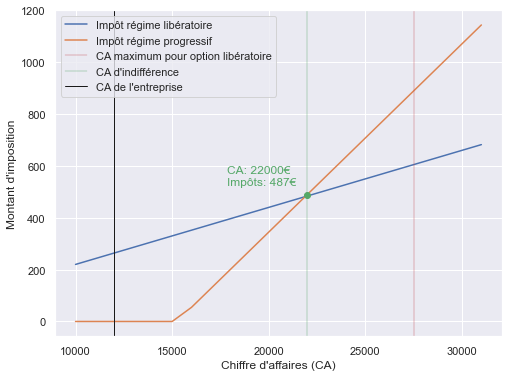

In [341]:
# Définition de la taille du graph
plt.figure(figsize=(8,6))

# Trace les lignes correspondant aux deux régimes
plt.plot(LISTE_CA, liste_impots_lib, \
         label='Impôt régime libératoire')
plt.plot(LISTE_CA, liste_impots_progress, \
         label='Impôt régime progressif')

# Ajout d'un marker et des coordonnées sur le point d'intersection
plt.plot(ca_intersec, imp_intersec, marker='o')
plt.annotate(text=intersec_coords, xy=(ca_intersec, imp_intersec), \
             xytext =(-80,10),
             textcoords="offset points",
             color='g')

# Ajout du CA limite pour lequel l'option libératoire est possible
plt.axvline(limite_ca_option,
            label="CA maximum pour option libératoire",
            linewidth=.4, color='r')

# Ajout du CA d'intersection
plt.axvline(ca_intersec,
            label="CA d'indifférence",
            linewidth=.4, color='g')

# Ajout du CA perso de l'entreprise
plt.axvline(CA_PERSO_BRUT,
            label="CA de l'entreprise",
            linewidth=1, color='k')

# Labels
plt.xlabel("Chiffre d'affaires (CA)")
plt.ylabel("Montant d'imposition")

plt.legend()
plt.show()

## Conclusion :
- Il faut avoir un CA > 20000€ pour que ça devienne intéressant de
bénéficier de l'option libératoire de l'impôt sur le revenu.
- Il est possible d'en bénéficier uniquement si le revenu fiscal
de référence N-2 est inférieur à 27519€ (si quot. familial = 1).
- Donc impot libératoire intéressant entre 21000€ et 27519€ pour ma situation.